In [1]:
import argparse
import os, sys
import time
import string
import pprint
import json

# http://anie.me/On-Torchtext/
import torch
import torch.nn as nn
import revtok
import nltk
import spacy
spacy_en = spacy.load('en')

from datasets import dataset_map
from model import *
from torchtext.vocab import GloVe
from torchtext import data
from torchtext.data import Field
from torchtext.data import Iterator, BucketIterator

# import matplotlib
# matplotlib.use('Agg')
import matplotlib.ticker as ticker
import numpy as np
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

In [2]:
from torchtext.data import Field
class SplitReversibleField(Field):

    def __init__(self, **kwargs):
        if kwargs.get('tokenize') is list:
            self.use_revtok = False
        else:
            self.use_revtok = True
        super(SplitReversibleField, self).__init__(**kwargs)

    def reverse(self, batch, mode='resp'):
        if self.use_revtok:
            try:
                import revtok
            except ImportError:
                print("Please install revtok.")
                raise
        if mode =='resp' and not self.batch_first:
            batch = batch.t()
        with torch.cuda.device_of(batch):
            batch = batch.tolist()
        detokenized = []
        for ex in batch:
            if mode=='resp':
                for ind in ex:
                    detokenized.append(self.vocab.itos[ind])
            else:
                detokenized.append(self.vocab.itos[ex])
        batch = detokenized  # denumericalize

        def trim(s, t):
            sentence = []
            for w in s:
                if w == t:
                    break
                sentence.append(w)
            return sentence

        batch = [trim(ex, self.eos_token) for ex in batch]  # trim past frst eos

        def filter_special(tok):
            return tok not in (self.init_token, self.pad_token)

        batch = [filter(filter_special, ex) for ex in batch]
        if self.use_revtok:
            return [revtok.detokenize(ex) for ex in batch]
        return [' '.join(ex) for ex in batch]

In [3]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
def showAttention(input_sentence, prediction, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(np.array(attentions).reshape(1,len(input_sentence)), vmin=0)        
    fig.colorbar(cax)
   
    # Set up axes
    ax.set_xticklabels([''] + input_sentence + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + ["cluster " + str(prediction)])

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [4]:
def update_stats(accuracy, confusion_matrix, logits, y):
  _, max_ind = torch.max(logits, 1)
  equal = torch.eq(max_ind, y)
  correct = int(torch.sum(equal))

  for j, i in zip(max_ind, y):
    confusion_matrix[int(i),int(j)]+=1

  return accuracy + correct, confusion_matrix

def train(model, data, optimizer, criterion, args):
  model.train()
  accuracy, confusion_matrix = 0, np.zeros((args['nlabels'], args['nlabels']), dtype=int)
  t = time.time()
  total_loss = 0
  for batch_num, batch in enumerate(data):
    model.zero_grad()
    x = batch.Text
    y = batch.Label

    logits, _ = model(x)
    loss = criterion(logits.view(-1, args['nlabels']), y)
    total_loss += float(loss)
    accuracy, confusion_matrix = update_stats(accuracy, confusion_matrix, logits, y)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), True)
    optimizer.step()

    print("[Batch]: {}/{} in {:.5f} seconds".format(
          batch_num, len(data), time.time() - t), end='\r', flush=True)
    t = time.time()

  print()
  print("[Loss]: {:.5f}".format(total_loss / len(data)))
  print("[Accuracy]: {}/{} : {:.3f}%".format(
        accuracy, len(data.dataset), accuracy / len(data.dataset) * 100))
#   print(confusion_matrix)
  return total_loss / len(data)

def evaluate(model, data, optimizer, criterion, mode='Valid', resp_list=None, attentions_list=None, prediction_list=None, ids_list=None):
  model.eval()
  accuracy, confusion_matrix = 0, np.zeros((10, 10), dtype=int)
  t = time.time()
  total_loss = 0

  with torch.no_grad():
    for batch_num, batch in enumerate(data):
      x = batch.Text
      reversed_x = TEXT.reverse(x)
      y = batch.Label
      ids = POST_ID.reverse(batch.Post_Id, mode='id')

      logits, attentions = model(x)
      reversed_examples = [reversed_x[i:i+x.shape[0]] for i in range(0, len(reversed_x), x.shape[0])]
    
      if mode == 'Test':
          for i,ex in enumerate(reversed_examples):
            if '<pad>' in ex:
                pad_start = ex.index('<pad>')
            else:
                pad_start = 0
            resp_list.append(ex[:pad_start])
            attentions_list.append(attentions.cpu().numpy()[i][0][:pad_start].reshape(1,pad_start))
            prediction_list.append(np.argmax(logits[i]))
            ids_list.append(ids[i])
    
      total_loss += float(criterion(logits.view(-1, 10), y))
      accuracy, confusion_matrix = update_stats(accuracy, confusion_matrix, logits, y)
      print("[Batch]: {}/{} in {:.5f} seconds".format(
            batch_num, len(data), time.time() - t), end='\r', flush=True)
      t = time.time()

  print("")
  print("[{} loss]: {:.5f}".format(type, total_loss / len(data)))
  print("[{} accuracy]: {}/{} : {:.3f}%".format(type,
        accuracy, len(data.dataset), accuracy / len(data.dataset) * 100))

  return total_loss / len(data)

In [5]:
cuda = torch.cuda.is_available()
device = torch.device("cpu") if not cuda else torch.device("cuda:0")

def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text)]

TEXT = SplitReversibleField(sequential=True,  tokenize=tokenizer)
LABEL = data.Field(sequential=False, use_vocab=False)
QUESTION = SplitReversibleField(sequential=True,  tokenize=tokenizer)
POST_ID = SplitReversibleField(sequential=False)

train_data, val_data = data.TabularDataset.splits(
  path='./data/', train='train_real.tsv',
  validation='val_real.tsv', format='csv', skip_header=True,
  fields=[('Text', TEXT), ('Label', LABEL), ('Post_Id', POST_ID)])

all_data = data.TabularDataset('./data/all.tsv',format='csv',skip_header=True,
                                 fields=[('Text', TEXT), ('Label', LABEL), ('Post_Id', POST_ID)])

TEXT.build_vocab(train_data, vectors="glove.6B.200d")
POST_ID.build_vocab(all_data)

#  sort_key=lambda x: len(x.Text)
val_iter = BucketIterator(val_data, 64, device=device, sort_within_batch=False,repeat=False)
train_iter = BucketIterator(train_data, 64, device=device, sort_within_batch=False, repeat=False)

In [6]:
args = {
    'nlabels': 10,
    'nlayers': 1,
    'hidden': 300,
    'bi': False,
    'emsize': 200,
    'epochs': 10,
    'lr': 0.0005
}
ntokens, nlabels = len(TEXT.vocab), 10
# args.nlabels = nlabels # hack to not clutter function arguments

embedding = nn.Embedding(ntokens, args['emsize'], padding_idx=1, max_norm=1)
# if vectors: embedding.weight.data.copy_(TEXT.vocab.vectors)
encoder = Encoder(args['emsize'], args['hidden'], nlayers=args['nlayers'])

attention_dim = args['hidden'] if not args['bi'] else 2*args['hidden']*args['hidden']
attention = Attention(attention_dim, attention_dim, attention_dim)

model = Classifier(embedding, encoder, attention, attention_dim, nlabels)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), args['lr'], amsgrad=True)

try:
    best_valid_loss = None

    for epoch in range(1, args['epochs'] + 1):
      train(model, train_iter, optimizer, criterion, args)
      loss = evaluate(model, val_iter, optimizer, criterion, args)

      if not best_valid_loss or loss < best_valid_loss:
        best_valid_loss = loss
except KeyboardInterrupt:
    print("[Ctrl+C] Training stopped!")        

Total param size: 2293010


RuntimeError: torch.cuda.LongTensor is not enabled.

In [7]:
resp_list = []
attentions_list = []
prediction_list = []
ids_list = []
loss = evaluate(model, val_iter, optimizer, criterion, mode='Test', resp_list=resp_list, attentions_list=attentions_list, prediction_list=prediction_list, ids_list=ids_list)

[Batch]: 59/60 in 0.03135 seconds
[<class 'type'> loss]: 2.14071
[<class 'type'> accuracy]: 1949/3836 : 50.808%


In [8]:
examples_with_attention = []
for (id_, attentions, resp, prediction) in list(zip(ids_list, attentions_list, resp_list, prediction_list)):
    attention_results = {}    
    attention_results['id'] = id_
    attention_results['attentions'] = attentions[0].tolist()
    attention_results['resp'] = resp
    attention_results['prediction'] = int(prediction.data)
    examples_with_attention.append(attention_results)
    
examples_with_attention[:5]

[{'id': 'BgkSu0FHBOL',
  'attentions': [0.0014492839109152555,
   0.0013834129786118865,
   0.001676958054304123],
  'resp': ['this', 'is', 'pork'],
  'prediction': 0},
 {'id': 'BdrsvXAAJHh',
  'attentions': [0.002321059349924326,
   0.002753353677690029,
   0.0033252269495278597,
   0.004589612130075693,
   0.00799478404223919],
  'resp': ['night', 'market', 'in', 'phnom', 'penh'],
  'prediction': 6},
 {'id': 'Bg9yxyGgyRC',
  'attentions': [9.961897740140557e-05,
   0.000103166421467904,
   0.00010151312744710594,
   0.00010820836178027093,
   0.0003248398716095835,
   0.0012972071999683976,
   0.0025823048781603575,
   0.00818632636219263,
   0.015363851562142372,
   0.020700780674815178,
   0.024472765624523163,
   0.03154138848185539,
   0.03745906427502632,
   0.044190142303705215,
   0.04316677153110504,
   0.04427710548043251,
   0.047165315598249435,
   0.049717944115400314,
   0.04885859787464142,
   0.05155925825238228],
  'resp': ['that',
   's',
   'the',
   'black',
   'cr

In [9]:
import json
with open('examples_with_attention.json', 'w') as f:
    json.dump(examples_with_attention, f)

In [10]:
def remove_nonascii(text):
    return ''.join([i if ord(i) < 128 else ' ' for i in text])

def clean_answer(response):
    # Remove non-ascii characters, and username tags
    answer = remove_nonascii(response).lower()
    answer = answer.split(' ')
    answer = [w for w in answer if not w.startswith('@')]
    answer = ' '.join(answer)
    
    # Remove unnecessary spaces
    answer = answer.strip()

    # Remove punctuation
    answer = answer.translate(str.maketrans('','',string.punctuation))
    return answer

In [12]:
results = []
fnames = ['results_g1200.json', 'results_g150.json', 'results_g1700.json', 'results_g450.json', 'results_g50.json', 'results_g50_redo.json', 'results_g750.json']
for fname in fnames:
    tasks = open('./' + fname).readlines()
    for task in tasks:
        results += json.loads(task)['output']
    
    results_cleaned = []
    result_questions = []
    result_responses = []
    result_post_ids = []
    for i, result in enumerate(results):
        if "not possible" not in result['answer']:
            data = result['info']
            if '?' in data['response']: # uncertainty expressed by answer
                continue

            question = data['question']
            response = clean_answer(data['response'])
            result_questions.append(question)
            result_responses.append(response)
            result_post_ids.append(data['post_id'])
            results_cleaned.append(result)

In [13]:
results[:1]

[{'info': {'username': 'calinolke',
   'url': 'https://scontent-lax3-2.cdninstagram.com/vp/1e96033c0069dcb4d0417312afb09b0a/5B61ED93/t51.2885-15/e35/28432651_1799963446967198_5783510146550333440_n.jpg',
   'question': 'where is the sign ?',
   'post_id': 'Bf4V4BFgpgu',
   'pub_date': '03-03-2018',
   'response': 'the link is in my bio or you can go to my IG page to hear a clip'},
  'answer': 'not possible\n',
  'explanation': ''}]

Question:  where are the people ?
Human response:  night market in phnom penh
Turker response:  ['phnom', 'penh']
Model's response:  ['market', 'in', 'Phnom', 'Penh']


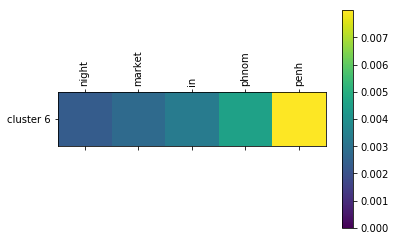


Question:  What on earth are the crumbs that are covering this watermelon?
Human response:  and dried garlic
Turker response:  ['dried', 'garlic']
Model's response:  ['and', 'dried', 'garlic']


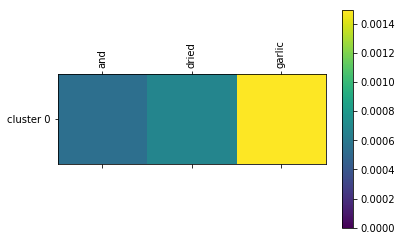


Question:  where is the light ?
Human response:  the sin
Turker response:  ['the', 'sin']
Model's response:  ['the', 'sin']


/home/shared/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


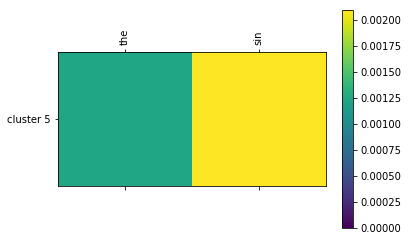


Question:  what is in front of the bed ?
Human response:  thats just a vintage headboard
Turker response:  ['a', 'vintage', 'headboard']
Model's response:  ['that', 's', 'just', 'a', 'vintage', 'headboard']


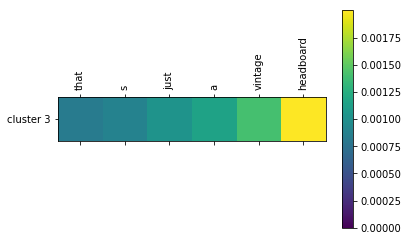


Question:  what is the woman wearing ?
Human response:  viola sell
Turker response:  ['viola', 'sell']
Model's response:  ['viola', 'sell']


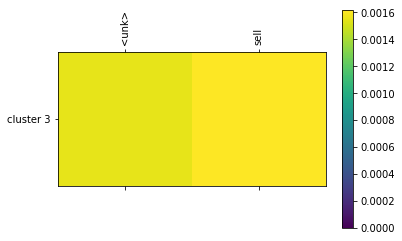


Question:  where is the dog ?
Human response:  in moscow
Turker response:  ['moscow']
Model's response:  ['in', 'Moscow']


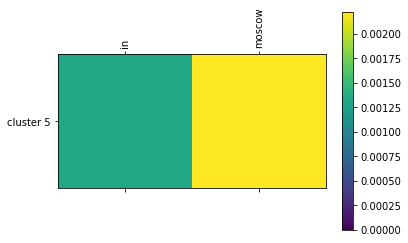

ValueError: 'BduRjXmFzXu' is not in list

In [14]:
bleu2_total = 0.0
bleu3_total = 0.0
count = 0    
for i, example in enumerate(examples_with_attention):
    post_id = example['id']
    example_idx = result_post_ids.index(post_id)
    result = results_cleaned[example_idx]
    human = [word.lower() for word in result['answer'].split()]
    if "not" not in human and 'n/a' not in human:
        data = result['info']
        if '?' in data['response']: # uncertainty expressed by answer
            continue
        question = data['question']    
        response = clean_answer(data['response'])

        bad_human = False
        for hword in human:
            if hword not in response.split():
                bad_human = True
                break
        if bad_human:
            continue
        
        answer = []
        tokenized_response = tokenizer(data['response'])
        attentions = example['attentions']
        if len(attentions) > 0 and len(attentions) == len(tokenized_response):
            max_attn = max(attentions)
            for i,attn in enumerate(attentions):
                if attn >= max_attn / 3.:
                    answer.append(tokenizer(data['response'])[i])
            count += 1
            print ("Question: ", question)
            print("Human response: ", response)
            print ("Turker response: ", human)
            print ("Model's response: ", answer)
            showAttention(example['resp'], example['prediction'], attentions)
            print()
            bleu2 = nltk.translate.bleu_score.sentence_bleu([human], answer, weights=(1./2, 1./2))
            bleu3 = nltk.translate.bleu_score.sentence_bleu([human], answer, weights=(1./3, 1./3, 1./3))
            bleu2_total += bleu2
            bleu3_total += bleu3

if count == 0:
    print(0.0 )
else:
    print (bleu2_total / count )
    print (bleu3_total / count )    

In [ ]:
print (bleu2_total / count )
print (bleu3_total / count )    